In [37]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import cv2
from numba import cuda
import matplotlib.pyplot as plt
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC, kspaceFirstOrder2DG
from kwave.utils import *
from kwave.utils import dotdict
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load in 3D Vessel Data

In [38]:
data_path='/mnt/WD6TB/tianaoli/skinVessel/'
data = scio.loadmat(os.path.join(data_path, '899.mat'))
skin = np.array(data['skin'], dtype=float)
print(skin.shape)

(128, 128, 64)


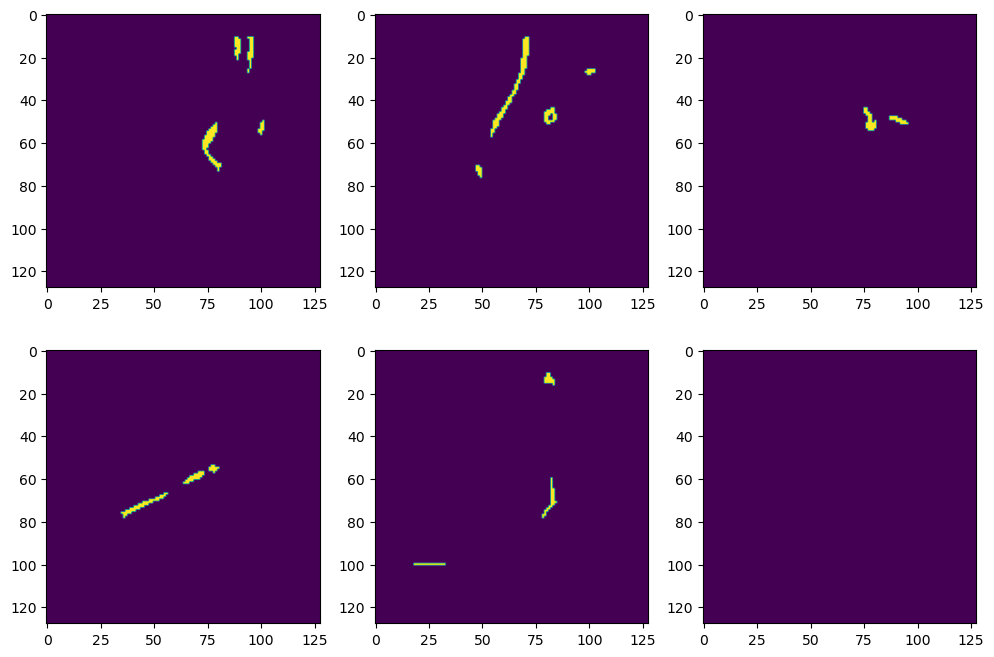

In [39]:
fig = plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(skin[:,:,5*i+11])

In [40]:
gt = skin[:,:,16]
gt -= gt[0,0]

In [41]:
pathname = gettempdir()

PML_size = 20                               # Size of the PML in grid points.
Nx, Ny = gt.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 1.1*2*R_ring/Nx, 1.1*2*R_ring/Ny   # Grid point spacing in the y direction [m].
DelayDistance_step = 0.00001
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
T_sample = 1/40e6                           # Sample time step [s].

N_transducer = 256                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi

Define SOS distribution.

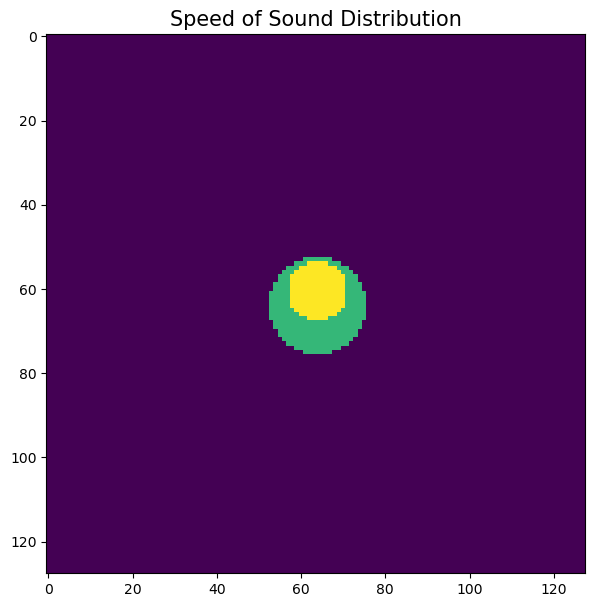

In [42]:
sos_background = 1500          # [m/s]
R, R1= 0.01, 0.006          # [m]
offset = 0.003              # [m]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
SoS = np.ones((Ny, Nx)) * 1500
SoS[XX**2 + YY**2 < R**2] = 1600
SoS[XX**2 + (YY + offset)**2 < R1**2] = 1650
rou = 1000                  # Density.
medium = kWaveMedium(sound_speed=1500, density=rou, sound_speed_ref=sos_background)

plt.figure(figsize=(7,7))
plt.title('Speed of Sound Distribution', fontsize=15)
plt.imshow(SoS)

### K-wave Forward Simulation

In [43]:
source = kSource()
source.p0 = gt

# smooth the initial pressure distribution and restore the magnitude
source.p0 = smooth(source.p0, True)


cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
# assign to sensor structure
sensor = kSensor(cart_sensor_mask)

# create the time array
kgrid.makeTime(medium.sound_speed)

# set the input arguements: force the PML to be outside the computational
# grid switch off p0 smoothing within kspaceFirstOrder2D
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False
}

# run the simulation
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 05-Mar-2023-21-33-02
Running k-Wave simulation...
  start time: 05-Mar-2023-21-33-02
  reference sound speed:  1500 m/s
  reference sound speed:  1500.0 m/s
  dt:  171.875ns , t_end: 103.6406us , time steps: 604
  input grid size: 128 by 128 grid points (110.00000000000001 by 110.00000000000001 m)
  maximum supported frequency:  872.7273k Hz
  expanding computational grid...
  computational grid size: 168 by 168 grid points
  precomputation completed in  0.004664911888539791 s
  saving input files to disk...
  completed in  0.37168302573263645 s
(256, 604)


Text(0, 0.5, 'Detector')

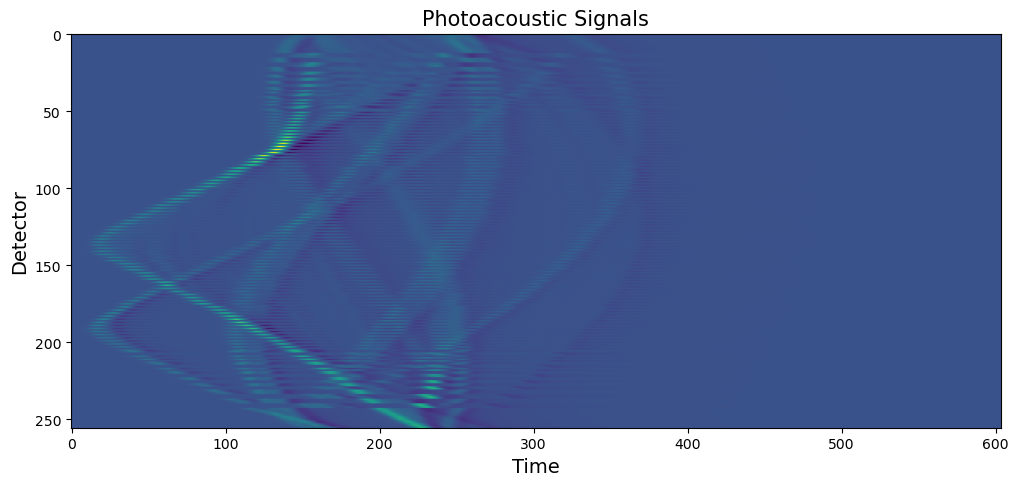

In [44]:
plt.figure(figsize=(12,6))
plt.imshow(sensor_data)
plt.title('Photoacoustic Signals', fontsize=15)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Detector', fontsize=14)

### DAS Reconstruction

In [ ]:
# @cuda.jit
def DelayAndSumReconstruction(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY):
# DESCRIPTION:
#     Generate a 2D Delay And Sum reconstructed PACT image of ring
#     transducer array
#
# INPUTS:
#     R_ring          - The R_ring [m] of the ring transducer array.
#     T_sample        - Sample time interval of the signals [s].
#     V_sound         - The sound speed [m/s] used for Delay And Sum 
#                     reconstruction.
#     ImageX          - The vector [m] defining the x coordinates of the
#                     grid points on which the reconstruction is done. The
#                     values in the vector should be unifromly-spaced in
#                     ascending order. The origin of the cartesian
#                     coordinate system is the center of the ring array.
#     ImageY          - The vector [m] defining the y coordinates of the
#                     grid points on which the reconstruction is done. The
#                     values in the vector should be unifromly-spaced in
#                     ascending order.
#     Sinogram        - A 2D matrix and each column of it is the signal
#                     recievde by one transducer. The nummber of
#                     transducers should be the number of columns. The
#                     transducers should be evenly distributed on a circle
#                     in counterclockwise arrangement and the first column
#                     correspond to the transducer in the dirrection 1 *
#                     2pi/N in the first quartile. The first sample should
#                     be at time 0 when the photoacoustic effect happens.
# 
# OUTPUTS:
#     Image           - A matrix whose size is length(ImageY) times
#                     length(ImageX). Image(t, s) is the reconstructed
#                     photoacoustic amplitude at the grid point (ImageX(s),
#                     ImageY(t)).

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * np.arange(N_transducer,)

    x_transducer = R_ring * np.cos(angle_transducer)
    y_transducer = R_ring * np.sin(angle_transducer)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2)
            for k in range(N_transducer):
                id = np.int(distance_to_transducer[k]/(V_sound * T_sample)) + 1
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

recon = DelayAndSumReconstruction(R_ring, kgrid.dt, medium.sound_speed, sensor_data, kgrid.x_vec, kgrid.y_vec)
# cuda.synchronize()

/tmp/ipykernel_2627427/2441310376.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  id = np.int(distance_to_transducer[k]/(V_sound * T_sample))


In [46]:
# recon = np.zeros((Nx,Ny))
# angle = 2 * np.pi / N_transducer
# fr = 1/kgrid.dt
# vs = medium.sound_speed[0]

# for i in range(Nx):
#     for j in range(Ny):
#         pa = 0
#         for k in range(N_transducer):
#             t = floor(np.sqrt(((j-N_transducer/2)*dx - (np.cos(k*angle-np.pi)*R_ring))**2 + ((i-N_transducer/2)*dy - (np.sin(k*angle-np.pi)*R_ring))**2) / vs*fr) + 1
#             pa += sensor_data[k,t]
#         recon[i,j] = pa

### K-wave Time Reversal

In [47]:
# # assign to the source structure
# source = kSource()
# source.p0 = np.zeros((Nx,Ny))
# source.p_mask = np.ones(kgrid.k.shape)

# cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
# # assign to sensor structure
# sensor_mask = cart_sensor_mask
# sensor = kSensor(cart_sensor_mask)

# # create the time array
# kgrid.makeTime(medium.sound_speed)
# sensor.time_reversal_boundary_data = sensor_data

# # set the input arguements: force the PML to be outside the computational
# # grid switch off p0 smoothing within kspaceFirstOrder2D
# input_args = {
#     'PMLInside': False,
#     'PMLSize': PML_size,
#     'Smooth': False,
#     'SaveToDisk': os.path.join(pathname, f'input.h5'),
#     'SaveToDiskExit': False
# }
# recon = kspaceFirstOrder2DG(**{
#     'medium': medium,
#     'kgrid': kgrid,
#     'source': source,
#     'sensor': sensor,
#     **input_args
# })

Text(0.5, 1.0, 'Ground Truth')

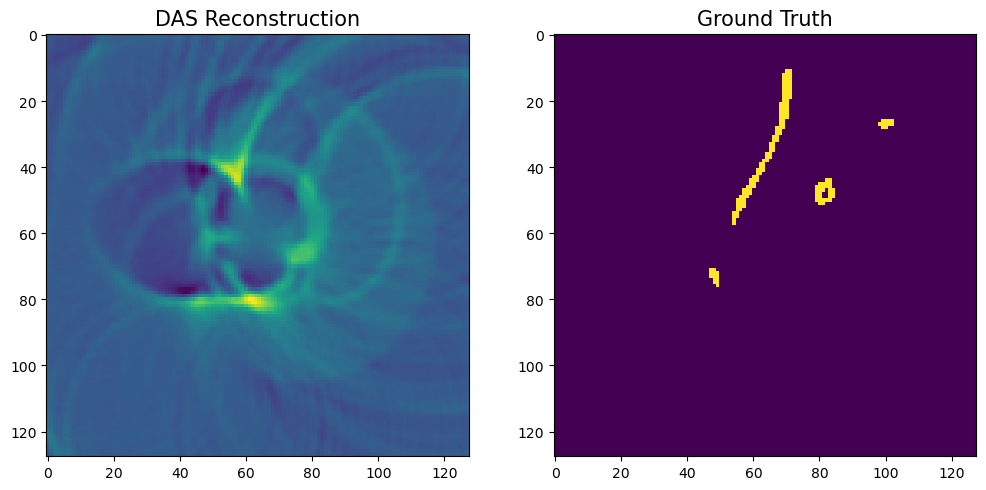

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(recon)
plt.title('DAS Reconstruction', fontsize=15)

plt.subplot(1,2,2)
plt.imshow(gt)
plt.title('Ground Truth', fontsize=15)